# **Agricultural drought in central South America - preparing CORDEX data for analysis**

In [139]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *; from wwa_indices import get_spi

---
## **Pre-processing**
Time series, spatial patterns & seasonal cycle all extracted from data downloaded using synda

### **Loop over models, extracting daily time series & spatial pattern**

In [ ]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

# can no longer convert kg/m^2/s to mm/day for some reason: this is out by a factor of 1000
units = {"tas" : "degC", "pr" : "mm/day", "evspsblpot" : "kg m-2 day-1"}

In [ ]:
for fpath in glob.glob("../synda/data/CORDEX/SAM-*/*/*/*/day/pr") + glob.glob("../synda/data/CORDEX/SAM-*/*/*/*/day/evspsblpot") + glob.glob("../synda/data/CORDEX/SAM-*/*/*/*/day/tas"):
    
    if "RegCM4-3" in fpath: continue
    print(fpath)
    varnm = fpath.split("/")[-1]
    
    # list available files
    fl_hist = sorted(glob.glob(fpath+"/*historical*.nc"))
    fl_rcp = sorted(glob.glob(fpath+"/*rcp85*.nc"))
    
    fnm = "data/"+re.sub("_[0-9]{8}-", "_"+fl_hist[0][-20:-12]+"-", fl_rcp[-1].split("/")[-1])
    sp_fnm = re.sub("[0-9]{8}=[0-9]{8}", "19800101-20221231", re.sub("day", "ond-spatial", fnm))
    
    if len(glob.glob(fnm)) > 0 and len(glob.glob(sp_fnm)) > 0: 
        continue

    # manually concatenate the files - some have mismatched coordinate labels
    da_hist = xr.concat([xr.open_dataset(fnm) for fnm in fl_hist], "time")[varnm]
    da_rcp = xr.open_mfdataset(fl_rcp)[varnm]
    
    da = convert_units_to(xr.concat([da_hist, da_rcp], "time"), units[varnm])
    axs = [da.cf.axes["X"][0], da.cf.axes["Y"][0]]
    
    # if LSM exists, mask land only
    lsm_fnm = re.sub("r[0-9]?i[0-9]p[0-9]", "r0i0p0", re.sub("day/pr", "fx/sftlf/*.nc", fpath))
    if len(glob.glob(lsm_fnm)) == 0:
        print("  no LSM")
    else:
        lsm = convert_units_to(xr.open_mfdataset(lsm_fnm).sftlf, "%")
        
        if "rlat" in axs:
            lsm = lsm.sel(rlat = da.rlat, rlon = da.rlon)
        else:
            lsm = lsm.sel(x = da.x, y = da.y)
        da = da.where(lsm)
        
    # create regionmask and save daily time series
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    ts = convert_calendar(da.where(rm == 1).dropna(axs[0], "all").dropna(axs[1], "all").mean(axs), "default", align_on = "date")
    ts.to_netcdf(fnm)
    
    # create spatial pattern of OND precip
    sp = da.sel(time = [m in [10,11,12] for m in da.time.dt.month]).sel(time = slice("1980", "2022")).mean("time")
    sp.to_netcdf(sp_fnm)
    
clear_output(wait = False)
print("Done.")

---
### **Time series for climate explorer**

#### **OND precipitation**

In [ ]:
for fnm in sorted(glob.glob("data/pr_*_*day_*.nc")):
    
    pr = xr.open_dataset(fnm).pr
    pr_ond = pr.resample(time = "QS-JAN").mean().groupby("time.month")[10]
    
    # ensure no partial months
    checksum = xr.ones_like(pr).resample(time = "QS-JAN").sum().groupby("time.month")[10]
    if "MOHC" in fnm:
        pr_ond = pr_ond.where(checksum >= 90)
    else:
        pr_ond = pr_ond.where(checksum >= 92)
    
    mdl = "_".join(fnm.split("_")[1:6])
    csv_fnm = "ts/CSA-drought_pr-ond_"+mdl+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+mdl+" OND precip central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# precip [mm/day] OND mean precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year precip"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr_ond.assign_coords(time = pr_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **OND temperature**

In [ ]:
for fnm in sorted(glob.glob("data/tas_*_*day_*.nc")):
    
    tas = xr.open_dataset(fnm).tas.reset_coords(drop = True)
    tas_ond = tas.resample(time = "QS-JAN").mean().groupby("time.month")[10]
    
    # ensure no partial months
    checksum = xr.ones_like(tas).resample(time = "QS-JAN").sum().groupby("time.month")[10]
    if "MOHC" in fnm:
        tas_ond = tas_ond.where(checksum >= 90)
    else:
        tas_ond = tas_ond.where(checksum >= 92)
    
    mdl = "_".join(fnm.split("_")[1:6])
    csv_fnm = "ts/CSA-drought_tas-ond_"+mdl+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+mdl+" OND tas central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# tas [degC] OND mean temperature at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year tas"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    tas_ond.assign_coords(time = tas_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **OND potential evapotranspiration**

In [ ]:
for fnm in sorted(glob.glob("data/evspsblpot_*_*day_*.nc")):
    
    pet = xr.open_dataset(fnm).evspsblpot
    pet_ond = pet.resample(time = "QS-JAN").mean().groupby("time.month")[10]
    
    # ensure no partial months
    checksum = xr.ones_like(pet).resample(time = "QS-JAN").sum().groupby("time.month")[10]
    if "MOHC" in fnm:
        pet_ond = pet_ond.where(checksum >= 90)
    else:
        pet_ond = pet_ond.where(checksum >= 92)
    
    mdl = "_".join(fnm.split("_")[1:6])
    csv_fnm = "ts/CSA-drought_pet-ond_"+mdl+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: CORDEX "+mdl+" OND pet central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pet [mm/day] OND mean potential evapotranspiration rate (evspsblpot) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pet"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pet_ond.assign_coords(time = pet_ond.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

---
## **Model evaluation**

### **Seasonal cycle**
Using CPC as single reference for seasonal cycle: values are very similar in CHIRPS

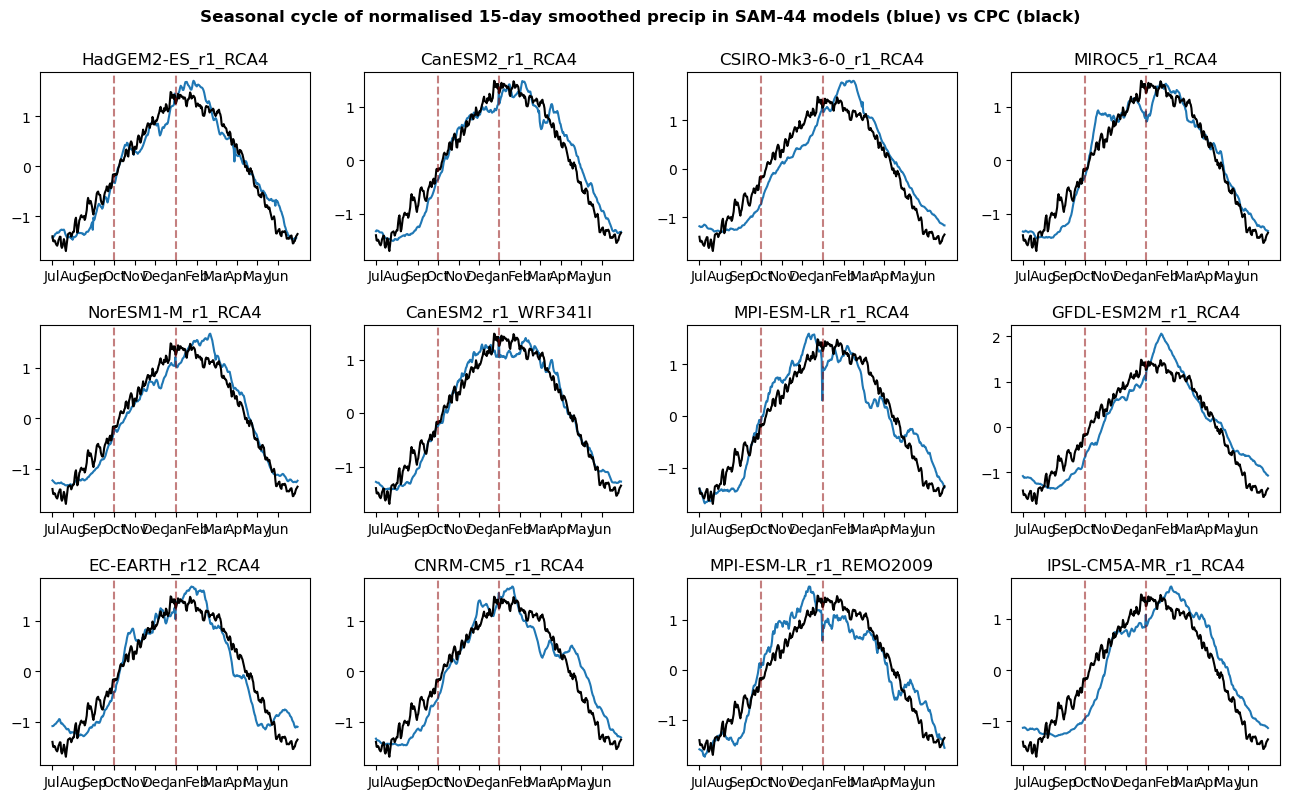

In [132]:
obs = pd.read_csv("data/cpc-tas-doy.txt", index_col = "dayofyear").to_xarray().tmean
obs = obs.reindex(dayofyear = obs.dayofyear.sortby((obs.dayofyear + y_offset(months = 7)) % 366))

models = [xr.open_dataset(fnm).pr.expand_dims(model = [cordex_model(fnm)]) for fnm in glob.glob("data/pr_SAM-44_*sc*")]

pr_dates = xr.open_dataset("data/cpc_CSA_daily.nc").precip.sel(time = slice("2019-07-01", "2020-06-30")).time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (16,9), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(models)):
    ax = fig.axes[i]
    pr = models[i].squeeze()
    
    pr = pr.reindex(dayofyear = pr.dayofyear.sortby((pr.dayofyear + y_offset(months = 7)) % 366))
    ax.plot((pr - pr.mean()) / pr.std())
    ax.plot((obs - obs.mean()) / obs.std(), label = "CPC", color = "k")
    ax.set_title(pr.model.values)
    [ax.axvline((datetime(2020,m,1).timetuple().tm_yday + y_offset(months = 7)) % 366, ls = "--", color = "darkred", alpha = 0.5) for m in [10,1]]
    sc_xlabels(pr_dates, ax = ax)

fig.suptitle("Seasonal cycle of normalised 15-day smoothed precip in SAM-44 models (blue) vs CPC (black)", fontweight = "bold", y = 0.95)
plt.savefig("cordex_pr_seasonal-cycle_SAM-44.png")

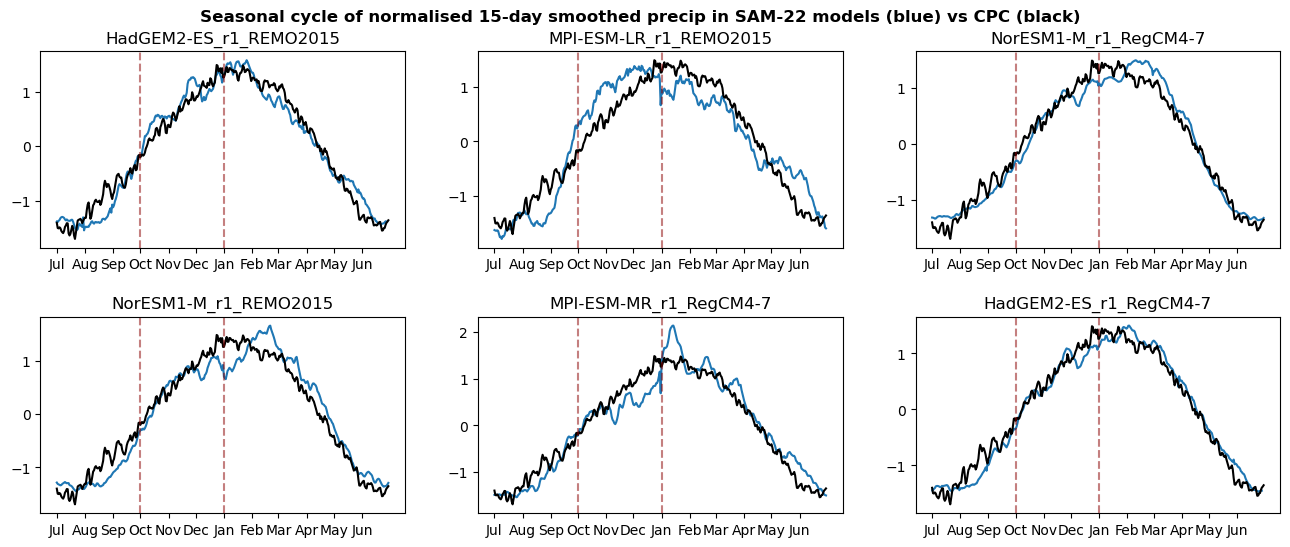

In [133]:
obs = pd.read_csv("data/cpc-tas-doy.txt", index_col = "dayofyear").to_xarray().tmean
obs = obs.reindex(dayofyear = obs.dayofyear.sortby((obs.dayofyear + y_offset(months = 7)) % 366))

models = [xr.open_dataset(fnm).pr.expand_dims(model = [cordex_model(fnm)]) for fnm in glob.glob("data/pr_SAM-22_*sc*")]

pr_dates = xr.open_dataset("data/cpc_CSA_daily.nc").precip.sel(time = slice("2019-07-01", "2020-06-30")).time

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (16,6), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(models)):
    ax = fig.axes[i]
    pr = models[i].squeeze()
    
    pr = pr.reindex(dayofyear = pr.dayofyear.sortby((pr.dayofyear + y_offset(months = 7)) % 366))
    ax.plot((pr - pr.mean()) / pr.std())
    ax.plot((obs - obs.mean()) / obs.std(), label = "CPC", color = "k")
    ax.set_title(pr.model.values)
    [ax.axvline((datetime(2020,m,1).timetuple().tm_yday + y_offset(months = 7)) % 366, ls = "--", color = "darkred", alpha = 0.5) for m in [10,1]]
    sc_xlabels(pr_dates, ax = ax)

fig.suptitle("Seasonal cycle of normalised 15-day smoothed precip in SAM-22 models (blue) vs CPC (black)", fontweight = "bold", y = 0.95)
plt.savefig("cordex_pr_seasonal-cycle_SAM-22.png")

### **Spatial pattern**

#### **SAM-44**

In [134]:
obs = [xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")[12].dropna("time", "all").sel(time = slice("1980", None)).mean("time").expand_dims(dataset = [ens]) for ens in ["chirps", "cpc", "mswep"]]
obs[2] = obs[2].sel(lat = slice(-50,-10), lon = slice(-80,-40))

models = [wrap_lon(xr.open_dataset(fnm).expand_dims(model = [cordex_model(fnm)]).pr) for fnm in glob.glob("data/pr_SAM-44*spatial*.nc")]
models = [m.sel(rlat = np.logical_and(m.lat >= -50, m.lat <= -10).sum(axis = 1) > 0, rlon = np.logical_and(m.lon >= -80, m.lon <= -40).sum(axis = 0) > 0) for m in models]
models = [m.dropna(m.dims[1], "all").dropna(m.dims[2], "all") for m in models]

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

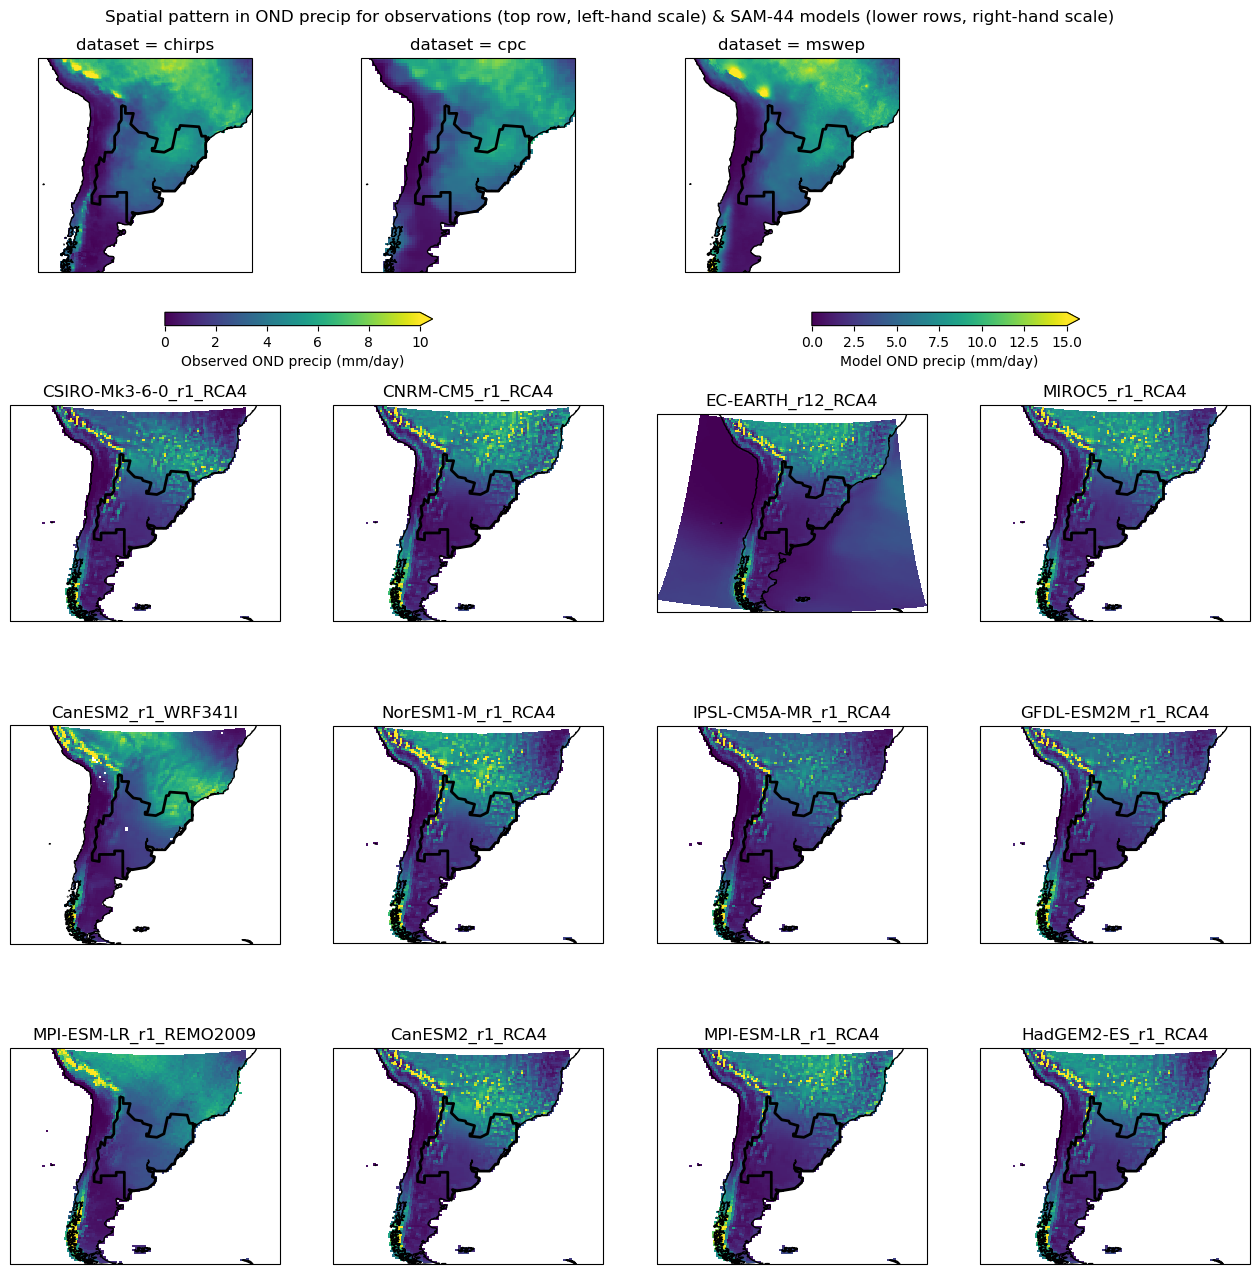

In [135]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (16,16), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

obs_kwargs = {"vmin" : 0, "vmax" : 10, "add_colorbar" : False}
model_kwargs = {"vmin" : 0, "vmax" : 15}

axs[0,3].set_axis_off()
for i in range(len(obs)):
    ax = axs[0,i]
    cbar_obs = obs[i].plot(ax = ax, **obs_kwargs)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)
    
for i in range(len(models)):
    ax = fig.axes[i+4]
    pr = models[i].squeeze()
    cbar_mdl = ax.pcolormesh(pr.lon, pr.lat, pr, **model_kwargs)
    ax.set_title(pr.model.values)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)

plt.colorbar(cbar_obs, ax = axs[0,:2], location = "bottom", fraction = 0.05, extend = "max", label = "Observed OND precip (mm/day)")
plt.colorbar(cbar_mdl, ax = axs[0,2:], location = "bottom", fraction = 0.05, extend = "max", label = "Model OND precip (mm/day)")

plt.suptitle("Spatial pattern in OND precip for observations (top row, left-hand scale) & SAM-44 models (lower rows, right-hand scale)", y = 0.91)
plt.savefig("cordex_pr-ond_spatial-patterns_SAM-44.png")

#### **SAM-22**

In [136]:
obs = [xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")[12].dropna("time", "all").sel(time = slice("1980", None)).mean("time").expand_dims(dataset = [ens]) for ens in ["chirps", "cpc", "mswep"]]
obs[2] = obs[2].sel(lat = slice(-50,-10), lon = slice(-80,-40))

models = [wrap_lon(xr.open_dataset(fnm).expand_dims(model = [cordex_model(fnm)]).pr) for fnm in glob.glob("data/pr_SAM-22*spatial*.nc")]
models = [m.sel(rlat = np.logical_and(m.lat >= -50, m.lat <= -10).sum(axis = 1) > 0, rlon = np.logical_and(m.lon >= -80, m.lon <= -40).sum(axis = 0) > 0) if "rlat" in m.dims else m for m in models ]
models = [m.sel(y = np.logical_and(m.lat >= -50, m.lat <= -10).sum(axis = 1) > 0, x = np.logical_and(m.lon >= -80, m.lon <= -40).sum(axis = 0) > 0) if "x" in m.dims else m for m in models]
models = [m.dropna(m.dims[1], "all").dropna(m.dims[2], "all") for m in models]

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

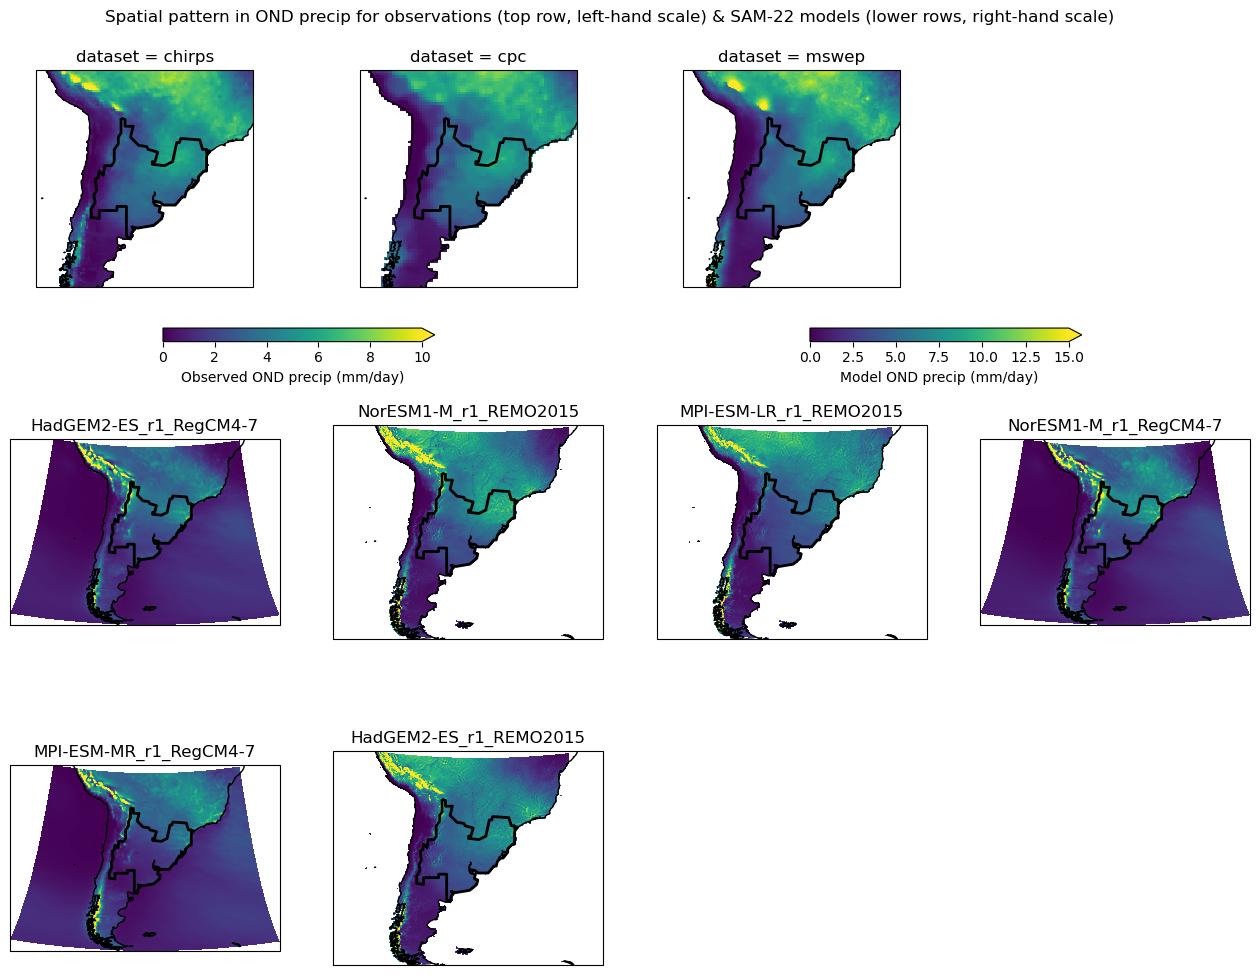

In [137]:
fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (16,12), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

obs_kwargs = {"vmin" : 0, "vmax" : 10, "add_colorbar" : False}
model_kwargs = {"vmin" : 0, "vmax" : 15}

axs[0,3].set_axis_off()
for i in range(len(obs)):
    ax = axs[0,i]
    cbar_obs = obs[i].plot(ax = ax, **obs_kwargs)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)
    
for i in range(len(models)):
    ax = fig.axes[i+4]
    pr = models[i].squeeze()
    cbar_mdl = ax.pcolormesh(pr.lon, pr.lat, pr, **model_kwargs)
    ax.set_title(pr.model.values)
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "k", lw = 2)

for i in range(len(models),8):
    fig.axes[i+4].set_axis_off()

plt.colorbar(cbar_obs, ax = axs[0,:2], location = "bottom", fraction = 0.05, extend = "max", label = "Observed OND precip (mm/day)")
plt.colorbar(cbar_mdl, ax = axs[0,2:], location = "bottom", fraction = 0.05, extend = "max", label = "Model OND precip (mm/day)")

plt.suptitle("Spatial pattern in OND precip for observations (top row, left-hand scale) & SAM-22 models (lower rows, right-hand scale)", y = 0.93)
plt.savefig("cordex_pr-ond_spatial-patterns_SAM-22.png")

### **Distribution of OND precip**


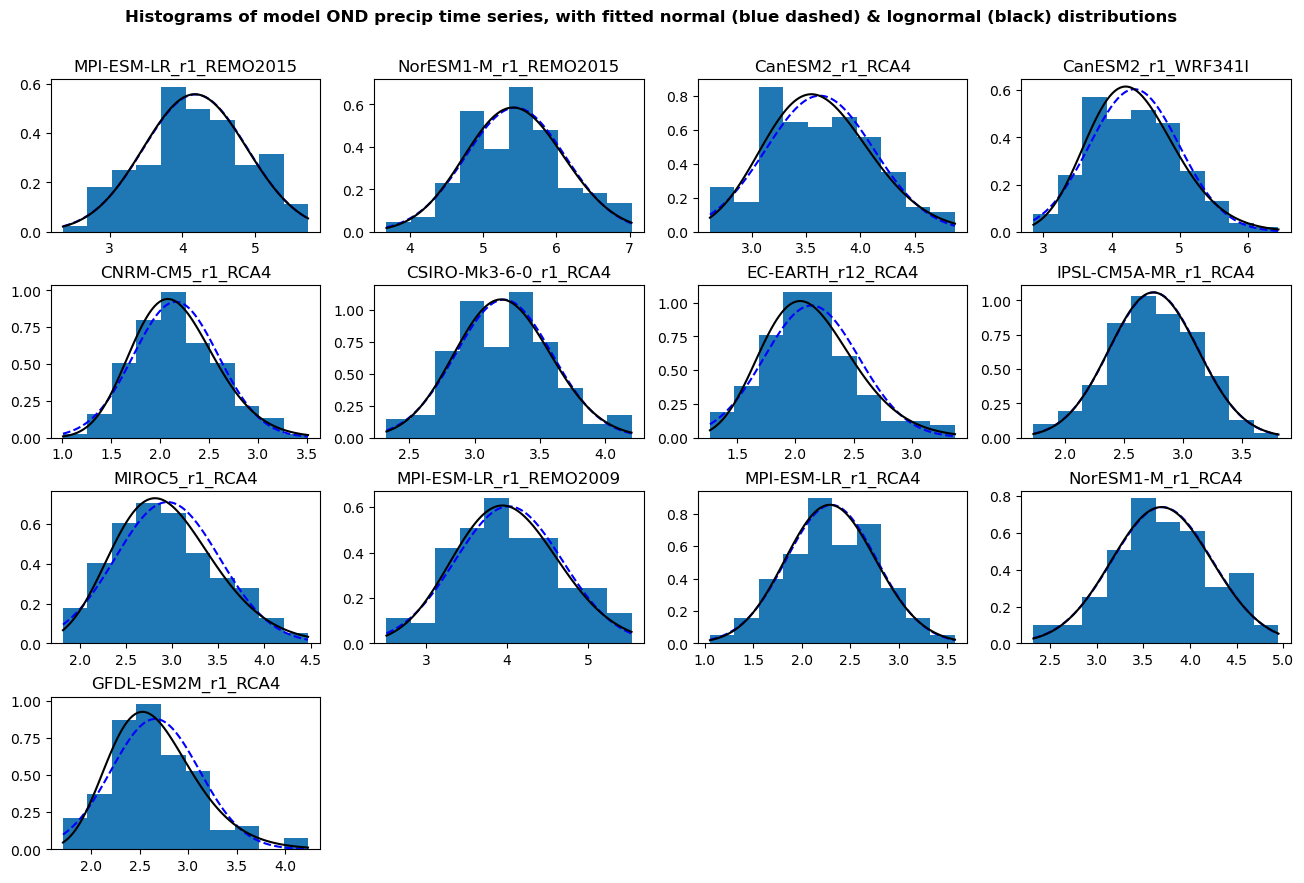

In [138]:
fl = sorted(glob.glob("ts/*pr-ond_SAM-*"))
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (16,10), dpi = 100)
fig.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    
    fnm = fl[i]
    ax = fig.axes[i]
    
    df = pd.read_csv(fnm, comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    df = df.loc[~np.isnan(df.precip)]
    x = np.linspace(df.min(), df.max(), 100)
    ax.plot(x, norm.pdf(x, *norm.fit(df)), color = "blue", label = "Gaussian", ls = "--")
    ax.plot(x, lognorm.pdf(x, *lognorm.fit(df)), color = "k", label = "lognormal")
    
    ax.hist(df, density = True)
    ax.set_title(cordex_model(re.sub(".dat", "", re.sub(".+CSA-drought_", "", fnm))))
    
for i in range(len(fl), len(fig.axes)):
    fig.axes[i].set_axis_off()
    
plt.suptitle("Histograms of model OND precip time series, with fitted normal (blue dashed) & lognormal (black) distributions", y = 0.95, fontweight = "bold")
plt.savefig("cordex_pr-ond_check-distributions.png")